# Data Augmentation
In this notebook, I will perform a complete data augmentation workflow to prepare an image dataset for training the classification model. The primary focus is correcting class imbalance which was found in the EDA step.

The process involves these key steps:

1. Performing a stratified train-validation-test split to ensure each data subset accurately reflects the overall class proportions.

2. Balancing the training set by up-sampling the minority classes. This is achieved by generating new images using a strong augmentation pipeline.

3. Saving the final, balanced, and structured dataset into a new directory, ready for model training.

In [1]:
import os
import shutil
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import sys, os
sys.path.append(os.path.abspath(".."))

from src.data import build_strong_transforms
from src.visualization import plot_class_distribution


## 0. Data Preparation Pipeline
This cell cleans up previous runs, finds all images and creates the output directory structure.

In [2]:
# Setting up
CONFIG_AUG = {
    "source_dir": "../data/images",
    "output_dir": "../data/augmented_images",
    "img_size": 128,
    "test_size": 0.15,
    "val_size": 0.15,
    "light_aug_fraction": 0.2,
    "seed": 42,
    "majority_aug_multiplier": 1.10
}

In [3]:
source_path = Path(CONFIG_AUG["source_dir"])
output_path = Path(CONFIG_AUG["output_dir"])

# --- CLEANUP PREVIOUS RUN AND COLLECT IMAGE PATHS ---
if output_path.exists():
    print(f"Output directory '{output_path}' already exists. Removing it.")
    shutil.rmtree(output_path)

all_files = []
for class_folder in source_path.iterdir():
    if class_folder.is_dir():
        # Supporting multiple image formats
        for img_file in list(class_folder.glob("*.jpg")) + list(class_folder.glob("*.png")):
            all_files.append((str(img_file), class_folder.name))

df = pd.DataFrame(all_files, columns=['filepath', 'class_name'])
class_names = df['class_name'].unique()

if len(df) == 0:
    print(f"Error: No images found in '{source_path}'. Please check the directory.")
else:
    print(f"Found {len(df)} total images in {len(class_names)} classes.")
    
    # Create directory structure
    for split in ["train", "val", "test"]:
        for class_name in class_names:
            os.makedirs(output_path / split / class_name, exist_ok=True)
    print(f"\nCreated directory structure in '{output_path}'")

Found 1422 total images in 8 classes.

Created directory structure in '../data/augmented_images'


## 1. Stratified Train-Validation-Test Split
This code block performs the stratified split to ensure that the class proportions are maintained in each set.

In [4]:
# The final split will be approx. 70% train, 15% val, 15% test
train_val_df, test_df = train_test_split(
    df, test_size=CONFIG_AUG["test_size"], random_state=CONFIG_AUG["seed"], stratify=df['class_name']
)
relative_val_size = CONFIG_AUG["val_size"] / (1 - CONFIG_AUG["test_size"])
train_df, val_df = train_test_split(
    train_val_df, test_size=relative_val_size, random_state=CONFIG_AUG["seed"], stratify=train_val_df['class_name']
)
print(f"Data split into: {len(train_df)} train, {len(val_df)} validation, {len(test_df)} test samples.")

Data split into: 994 train, 214 validation, 214 test samples.


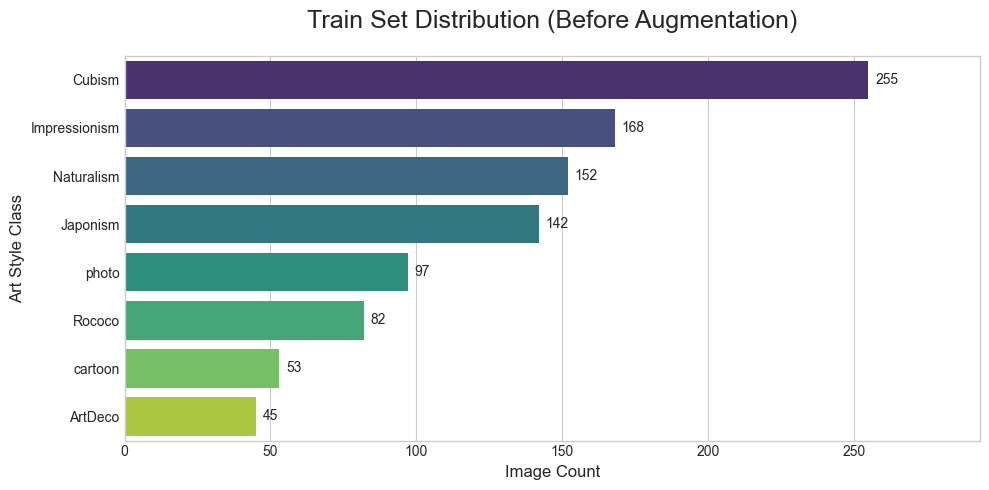

In [5]:
# Calculate the distribution
train_dist = train_df['class_name'].value_counts()
plot_class_distribution(train_dist, title='Train Set Distribution (Before Augmentation)')

## 2. Handle Validation and Test Sets
This cell copies the original images for the validation and test sets into the new directory structure without any augmentation.

In [6]:
print("Copying original validation and test images...")
for split_name, split_df in [('val', val_df), ('test', test_df)]:
    for _, row in tqdm(split_df.iterrows(), total=len(split_df), desc=f"Processing {split_name}"):
        dest_dir = output_path / split_name / row['class_name']
        shutil.copy(row['filepath'], dest_dir)

Copying original validation and test images...


Processing val:   0%|          | 0/214 [00:00<?, ?it/s]

Processing test:   0%|          | 0/214 [00:00<?, ?it/s]

## 3. Balance and Augment the Training Set
This is the core logic cell. It copies all original training images, then up-samples under-represented classes with strong augmentations and applies the same augmentations to a small fraction of the most common class.

A small random jitter is applied when determining target counts so that each class ends up with approximately — but not exactly — the same number of samples. This prevents the dataset from being artificially uniform and encourages better model generalization.

In [7]:
print("\nBalancing and augmenting the training set...")
train_class_counts = train_df['class_name'].value_counts()

# A multiplier to add a few augmentations to the largest class.
majority_aug_multiplier = 1.10 

base_target_count = int(train_class_counts.max() * majority_aug_multiplier)

strong_aug = build_strong_transforms(img_size=CONFIG_AUG["img_size"])

print(f"Base target count is ~{base_target_count}. Each class will be augmented to a slightly different final count.")

# --- Loop with Jitter ---
for class_name, group_df in tqdm(train_df.groupby('class_name'), desc="Augmenting Classes"):
    dest_dir = output_path / "train" / class_name
    original_filepaths = group_df['filepath'].tolist()
    current_count = len(original_filepaths)

    # First, copy all original files
    for fp in original_filepaths:
        shutil.copy(fp, dest_dir)

    # This creates a random target between 95% and 105% of the base target.
    jitter_factor = np.random.uniform(0.95, 1.05)
    class_target = int(base_target_count * jitter_factor)

    # Determine how many new images to generate for this specific class
    num_to_generate = class_target - current_count

        
    print(f"Class '{class_name}': Generating {num_to_generate} augmented images.")

    # Generate the new images using the strong pipeline
    for i in range(num_to_generate):
        source_path_str = np.random.choice(original_filepaths)
        image = cv2.imread(source_path_str)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        augmented = strong_aug(image=image)
        augmented_image = augmented["image"]

        new_filename = f"{Path(source_path_str).stem}_aug_{i}.jpg"
        cv2.imwrite(str(dest_dir / new_filename), cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))


Balancing and augmenting the training set...
Base target count is ~280. Each class will be augmented to a slightly different final count.


Augmenting Classes:   0%|          | 0/8 [00:00<?, ?it/s]

Class 'ArtDeco': Generating 237 augmented images.
Class 'Cubism': Generating 11 augmented images.
Class 'Impressionism': Generating 105 augmented images.
Class 'Japonism': Generating 134 augmented images.
Class 'Naturalism': Generating 132 augmented images.
Class 'Rococo': Generating 207 augmented images.
Class 'cartoon': Generating 232 augmented images.
Class 'photo': Generating 194 augmented images.


## 4. Final Verification
Finally, this cell prints the distribution of the newly balanced training set to confirm the script worked as expected.

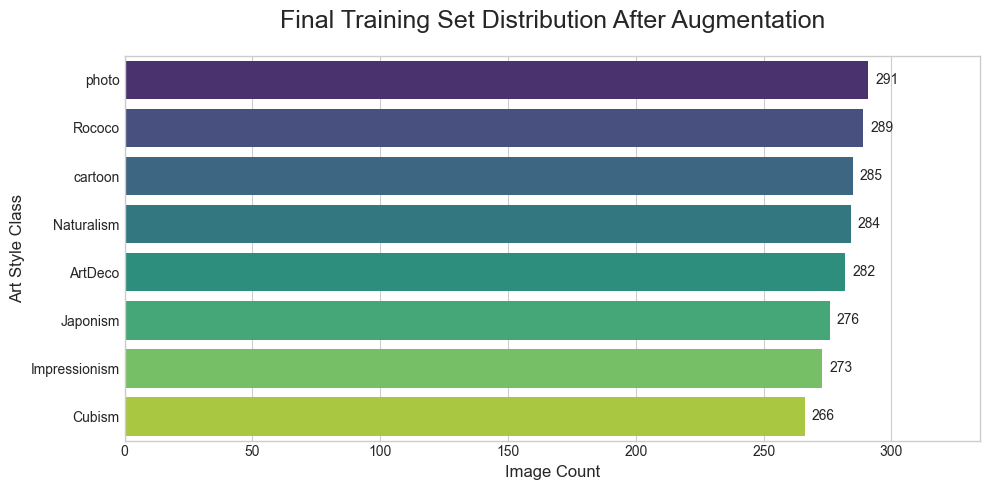

In [8]:
# --- CALCULATE AND VISUALIZE FINAL DISTRIBUTION ---
final_train_counts = {c: len(list((output_path / "train" / c).glob("*.*"))) for c in class_names}
final_dist_series = pd.Series(final_train_counts)


plot_class_distribution(
    final_dist_series, 
    title='Final Training Set Distribution After Augmentation'
)

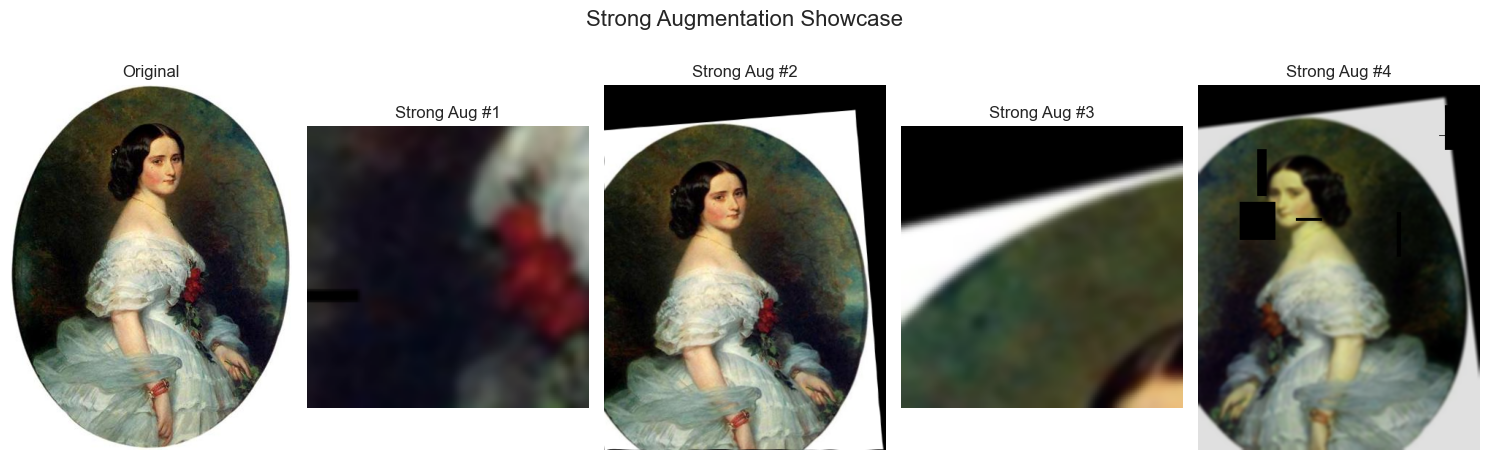

In [9]:
strong_aug = build_strong_transforms(img_size=CONFIG_AUG["img_size"])

# Find a sample image to demonstrate on
sample_image_path = df['filepath'].iloc[1]
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 5))
plt.suptitle("Strong Augmentation Showcase", fontsize=16)

# Original Image
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

# Strong Augmentations
for i in range(4):
    augmented = strong_aug(image=image)['image']
    plt.subplot(1, 5, i + 2)
    plt.imshow(augmented)
    plt.title(f"Strong Aug #{i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()